In [25]:
import os
import json
import glob
import random
import collections
import cv2
import shutil
import scipy
import time
import copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation, rc

import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models , datasets
from torch.optim import lr_scheduler

import tensorflow.python as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from PIL import Image
from tqdm.notebook import tqdm
from pathlib import Path

In [27]:
train_df=pd.read_csv('O:\\Ml\\archive\\png_data\\png_voxel_converted_ds\\train_labels.csv')

train_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   BraTS21ID   585 non-null    int64
 1   MGMT_value  585 non-null    int64
dtypes: int64(2)
memory usage: 9.3 KB


<Axes: xlabel='MGMT_value', ylabel='count'>

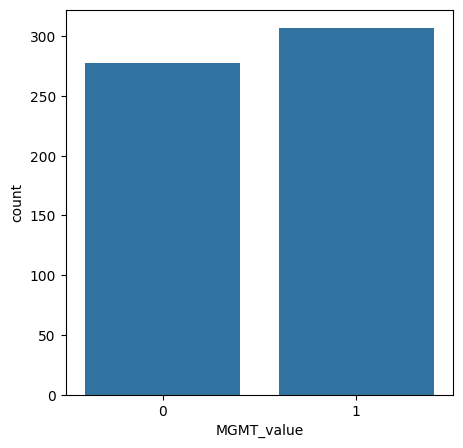

In [7]:
plt.figure(figsize=(5,5))
sns.countplot(data=train_df, x='MGMT_value')

## Visualize Traning Data

In [31]:
#load and convert the PNG MRI files to pixel arrays
def load_png_files(path):
    #open the png file using pillow
    image=Image.open(path)

    #convert the image to a Numpy array
    pixel_array=np.array(image)

    #normalize pixel values
    pixel_array=pixel_array-np.min(pixel_array)
    if np.max(pixel_array)!=0:
        pixel_array=pixel_array/np.max(pixel_array)

    #convert values to uint8 and scale to 0-255
    pixel_array=(pixel_array*255).astype(np.uint8)

    return pixel_array


#loads a sequence of PNG images from a directory
def load_image_list(path):
    #get the paths to the png files and sort them
    png_paths=sorted(
        glob.glob(os.path.join(path, '*.png')), #assuming all files are PNG format
        key=lambda x: int(x[:-4].split("-")[-1]),
    )

    #load the png files into a list
    images=[]
    for path in png_paths:
        image=load_png_files(path)
        # Check if the maximum pixel value is non-zero before appending to the list
        if image.max() != 0:
            images.append(image)

    return images

In [80]:
#visualize a sample of brain tumor radiogenomic data
def visualize_data(brats21id, slice_i, mgmt_value, types=('FLAIR', 'T1w', 'T1wCE', 'T2w')):
    plt.figure(figsize=(16,5))

    #construct the path to the patient's data folder based on the brats21id
    patient_path=os.path.join('O:\\Ml\\archive\png_data\\png_voxel_converted_ds\\train\\', str(brats21id).zfill(5))

    #loop over the specified image types
    for i,t in enumerate(types, 1):
        #find all images for the current type and sort them by the slice number
        type_paths=sorted(
            glob.glob(os.path.join(patient_path, t, '*')),
            key=lambda x: int(x[:-4].split('-')[-1]),
        )
        #load the pixel array for the specified slice index and type
        pixel_array=load_png_files(type_paths[int(len(type_paths)*slice_i)])
        #plot the current type's image in a subplot
        plt.subplot(1,4,i)
        plt.imshow(pixel_array, cmap='gray')
        plt.title(f"{t}")
        plt.axis('off')

    plt.suptitle(f"Patient ID:{brats21id} and MGMT Value:{mgmt_value}")
    plt.show()

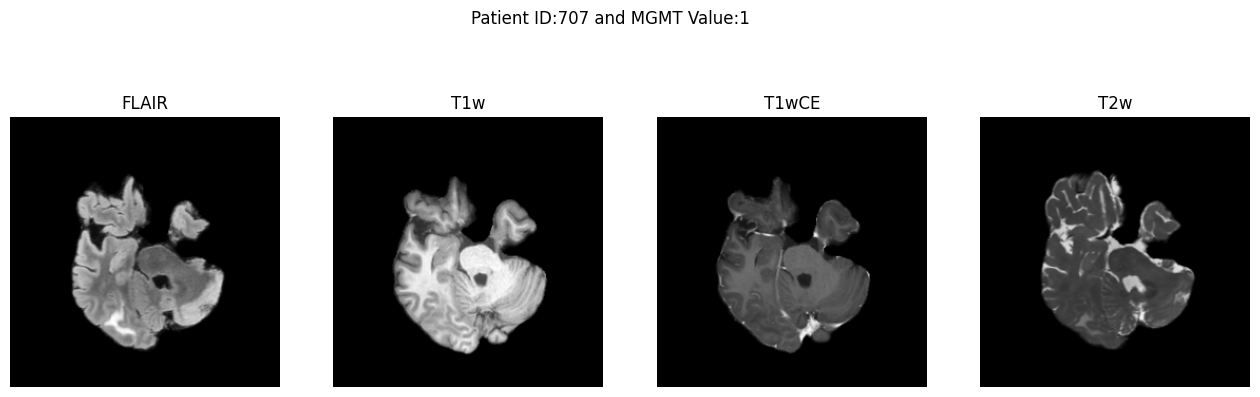

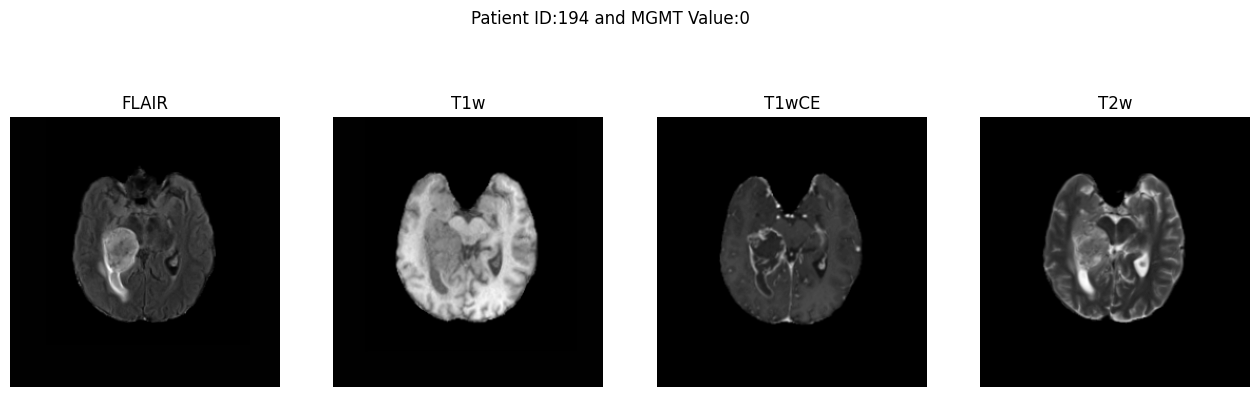

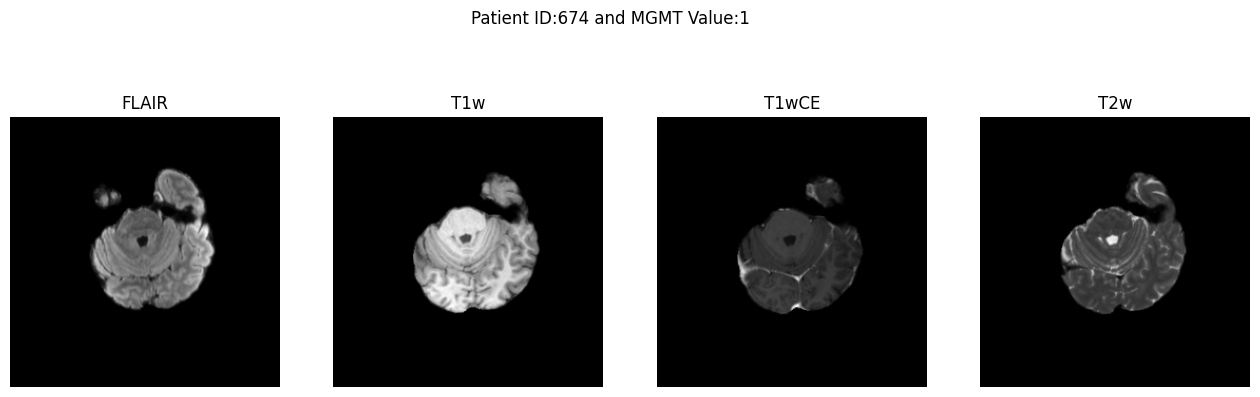

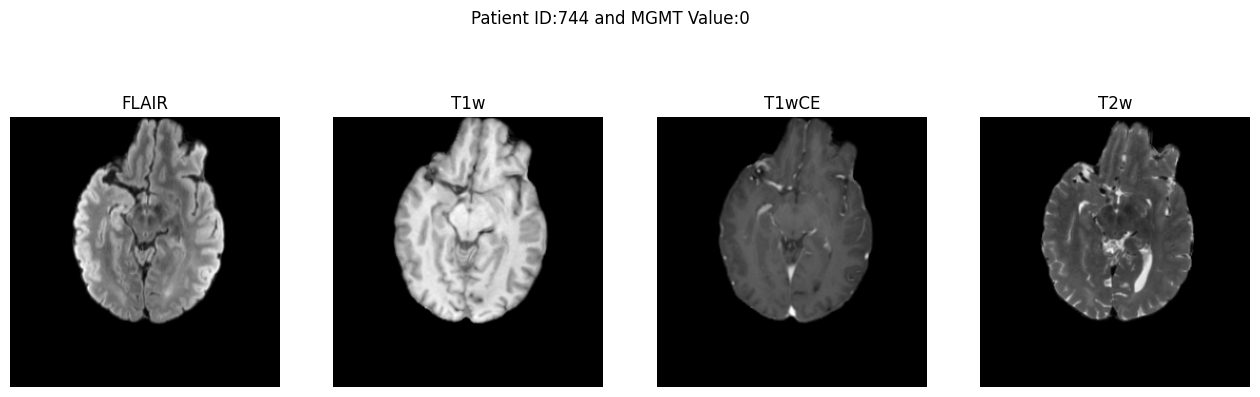

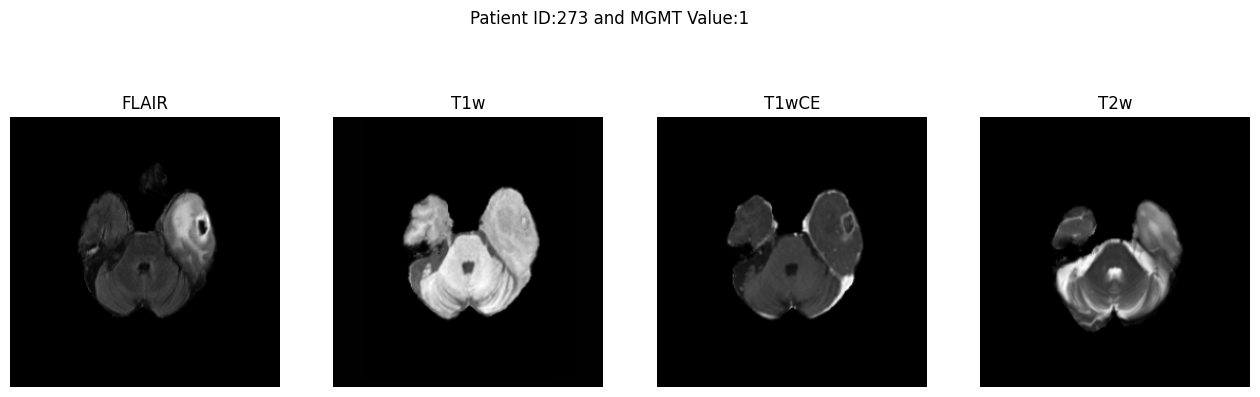

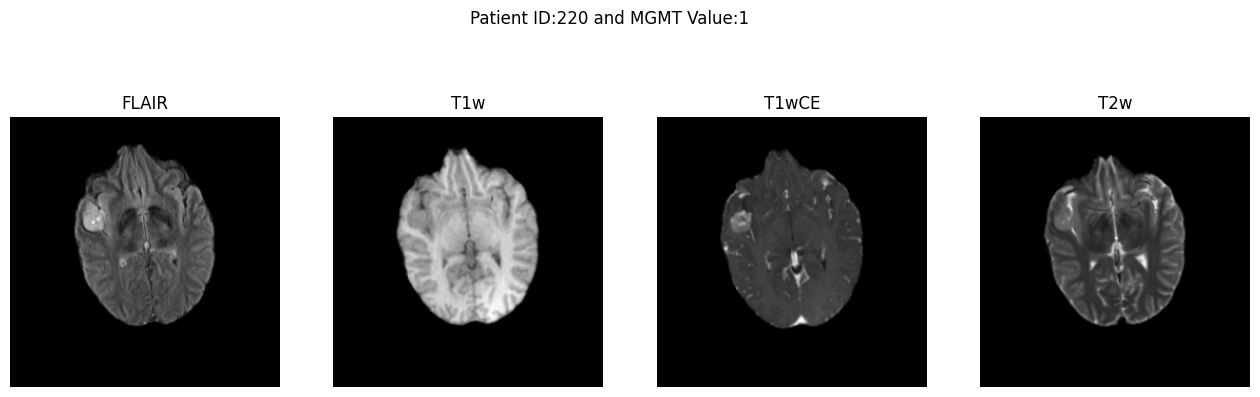

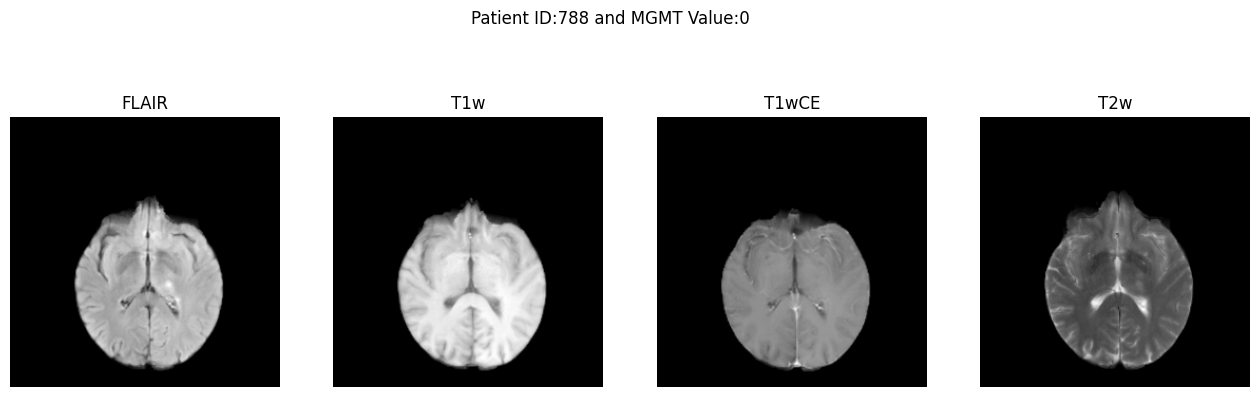

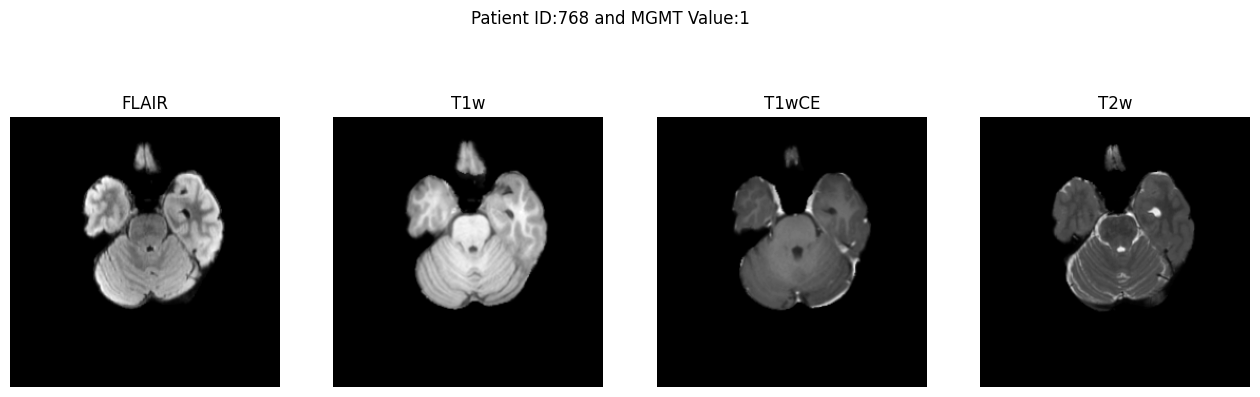

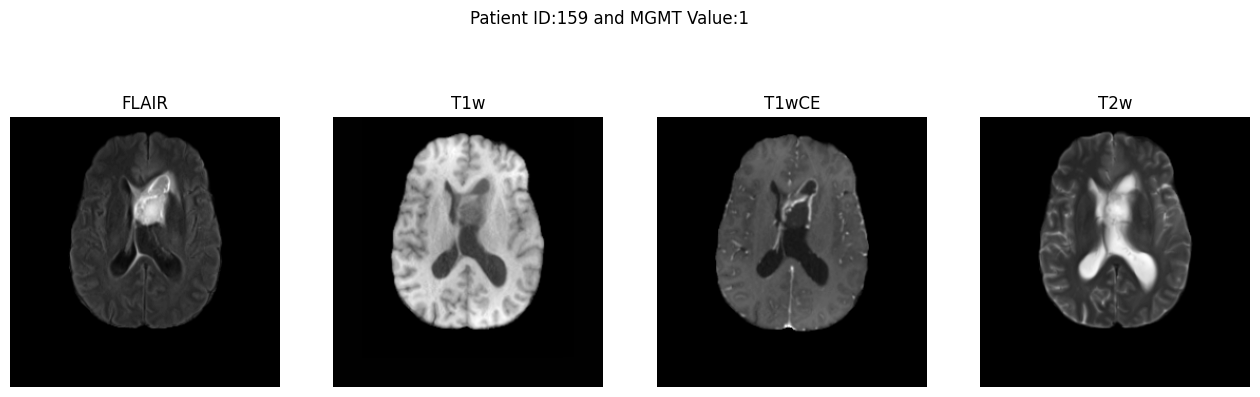

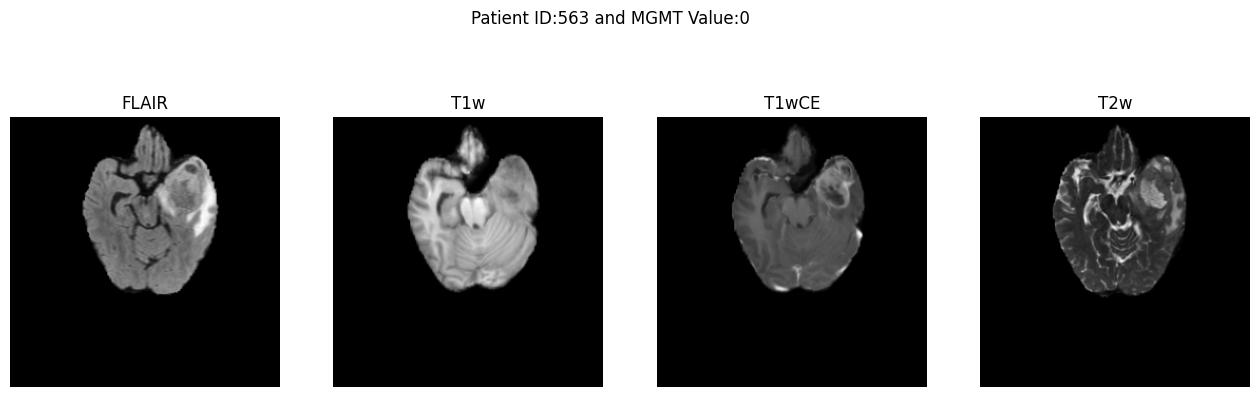

In [10]:
#select a random sample of 10 brain tumor MRI from the training dataset
random_samples=random.sample(range(train_df.shape[0]), 10)

#visualize each sample using the visualize_data()
for i in random_samples:
    brats21id=train_df.iloc[i]['BraTS21ID']
    mgmt_value=train_df.iloc[i]['MGMT_value']
    visualize_data(brats21id=brats21id, mgmt_value=mgmt_value, slice_i=0.5)

In [11]:
#set the backend for animations to 'jshtml'
rc('animation', html='jshtml')

#create an animation from a list of images
def animate_data(images):
    fig=plt.figure(figsize=(5,5))
    plt.axis('off')

    #display the first image in the list as the initial frame of the animation
    initial_frame=plt.imshow(images[0], cmap='gray')

    #update the displayed image for each frame
    def update_images(i):
        initial_frame.set_array(images[i])
        return [initial_frame]
    
    # Create a Matplotlib FuncAnimation object
    # Parameters:
    #   - fig: the figure to animate
    #   - update_images: the function to call for each frame
    #   - frames: the number of frames in the animation
    #   - interval: time between frames in milliseconds (1000 milliseconds = 1 second)
    return animation.FuncAnimation(fig, update_images, frames=len(images), interval=1000//24)

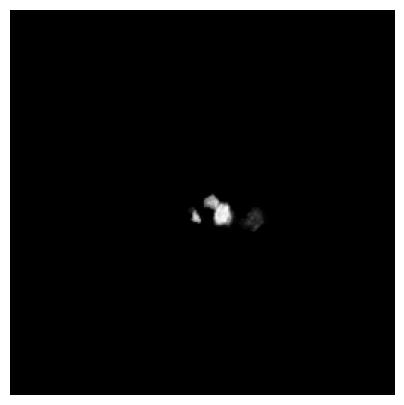

In [12]:
images=load_image_list('O:\\Ml\\archive\png_data\\png_voxel_converted_ds\\train\\00000\\FLAIR\\')
animate_data(images)

## Preparing a Dataset for a Machine Learning Model

First, all MRI images of the patients included in the _RSNA-MICCAI-Brain-Tumor-Radiogenomic-Classification_ are copied to `data/0 and data/1` folders according to their labels in the train_labels dataset. Among these `data` folders, MRI files that have a single color, that is, we can call them empty, are deleted. Afterwards, **TRAIN, VALIDATION and TEST** sets are created for each of the classes 0 and 1.

In [13]:
#create directories to store the dataset
!mkdir "data"
!mkdir "data/0"
!mkdir "data/1"

A subdirectory or file data already exists.
A subdirectory or file data/0 already exists.
A subdirectory or file data/1 already exists.


In [14]:

main_folder_path='O:\\Ml\\archive\\png_data\\png_voxel_converted_ds\\'
main_train_folder_path=os.path.join(main_folder_path, 'train\\')

#iterate over patient in the training data folder for classify the data according to labels and store the 0 and 1 folders
for patient in tqdm(os.listdir(main_train_folder_path)):
    patient_folder = os.path.join(main_train_folder_path , patient)
    #iterate over MRI types for each patient(subject)
    for mri_type in os.listdir(patient_folder):
        mri_type_folder = os.path.join(patient_folder, mri_type)
        #iterate over MRI images for each MRI type
        for mri_image in os.listdir(mri_type_folder):
            original_image_path = os.path.join(mri_type_folder , mri_image)
            mri_image = patient +'_'+ mri_type +'_'+ mri_image
            #extract subject number and find its corresponding row in the labels dataframe
            patient_num = int(patient)
            idx = np.where(train_df['BraTS21ID'] == patient_num)[0][0]
            #get the MGMT_value label for the subject
            label = str(train_df.loc[idx , 'MGMT_value'])
            #create new folder paths based on the label
            new_image_folder_path =os.path.join('data' , label)
            new_image_path = os.path.join(new_image_folder_path , mri_image)
            #copy the original image to the new folder structure
            shutil.copy(original_image_path , new_image_path)

  0%|          | 0/582 [00:00<?, ?it/s]

In [ ]:
print(f"Images with label 0={len(os.listdir('data/0'))}\nImages with label 1={len(os.listdir('data/1'))}")

Images with label 0=39744
Images with label 1=44064


In [ ]:
#iterate over subdirectories in the data folder and remove images that have only one color
for folder in os.listdir('data'):
    folder_name=str(folder)
    path='data/'+folder_name
    
    #iterate over filesin the current subdirectory(0 or 1)
    for file in tqdm(os.listdir(path)):
        img=Image.open(path+'/'+file)
        
        #get the colors present in the image
        clrs=img.getcolors()
        
        #check if the image has only one color, then remove the file
        if len(clrs)==1:
            os.remove(path+'/'+file)

  0%|          | 0/39744 [00:00<?, ?it/s]

  0%|          | 0/44064 [00:00<?, ?it/s]

In [ ]:
print(f"Images with label 0={len(os.listdir('data/0'))}\nImages with label 1={len(os.listdir('data/1'))}")

Images with label 0=31324
Images with label 1=34108


In [ ]:
#create directories to store the dataset split into training, validation, and testing sets
!mkdir "data/TRAIN"
!mkdir "data/TRAIN/1"
!mkdir "data/TRAIN/0"
!mkdir "data/VAL"
!mkdir "data/VAL/0"
!mkdir "data/VAL/1"
!mkdir "data/TEST"
!mkdir "data/TEST/0"
!mkdir "data/TEST/1"

In [ ]:
#split the data into training, validation, and testing sets
for mri_class in tqdm(['0', '1']):
    #get the total number of images for the current class
    img_num=len(os.listdir('./data/'+mri_class))
    #iterate over each image file in the current mri class (0 or 1)
    for (n, file_name) in enumerate(os.listdir('./data/'+mri_class)):
        img='./data/'+mri_class+'/'+file_name
        #check the index to determine whether to assign the imageto the training, validation, or testing set
        if n<4000:
            #copy the image to the testing set if it is one of the first 4000 images
            shutil.copy(img,'data/TEST/'+str(mri_class)+'/'+file_name)
        elif n<0.9*img_num:
            #copy the image to the training set if it is between the 4000th and 90% of the total images
            shutil.copy(img,'data/TRAIN/'+str(mri_class)+'/'+file_name)
        else:
            #copy the image to the validation set for the remaining 10% of images
            shutil.copy(img,'data/VAL/'+str(mri_class)+'/'+file_name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:

!rmdir /s /q "data/0"
!rmdir /s /q "data/1"

In [ ]:
print(f"data/TRAIN/1={len(os.listdir('data/TRAIN/1'))}\ndata/TRAIN/0={len(os.listdir('data/TRAIN/0'))}\ndata/VAL/1={len(os.listdir('data/VAL/1'))}\ndata/VAL/0={len(os.listdir('data/VAL/0'))}\ndata/TEST/1={len(os.listdir('data/TEST/1'))}\ndata/TEST/0={len(os.listdir('data/TEST/0'))}")

data/TRAIN/1=26698
data/TRAIN/0=24192
data/VAL/1=3410
data/VAL/0=3132
data/TEST/1=4000
data/TEST/0=4000


## Image Transformations using the PyTorch

These transformations are commonly used in deep learning models for image classification tasks. The training set transformations include random resizing, cropping, and flipping to enhance the model's ability to generalize to various orientations and scales. The validation and testing sets are standardized to maintain consistency during evaluation.

In [ ]:

mean=np.array([0.485,0.456,0.406])
std=np.array([0.229,0.224,0.225])

#define data transformations for different phases of the dataset (TRAIN, VAL, TEST)
data_transforms={
    'TRAIN': transforms.Compose([
        #transforms.RandomResizedCrop(224), #randomly resize and crop the image to 224*224 pixels
        transforms.RandomHorizontalFlip(), #randomly flip the image horizontally (augmentation technique)
        transforms.ToTensor(), #convert the image to a PyTorch tensor
        transforms.Normalize(mean, std) #normalize the image using the provided mean and standard deviation
    ]),
    'VAL': transforms.Compose([
        transforms.Resize(256), #resize the image to 256x256 pixels
        #transforms.CenterCrop(224), #center crop the image to 224x224 pixels
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'TEST': transforms.Compose([
        transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
#define data transformation for different phases of dataset (TRAIN, VAL, TEST)
image_dataset={phase: datasets.ImageFolder(os.path.join('./data', phase), data_transforms[phase])
                for phase in ['TRAIN', 'VAL', 'TEST']}

#create data loaders for each dataset (TRAIN, VAL, TEST)
dataloaders={phase: torch.utils.data.DataLoader(image_dataset[phase], batch_size=4, shuffle=True, num_workers=0)
                for phase in ['TRAIN', 'VAL', 'TEST']}

#get the sizes of each dataset
dataset_sizes={phase: len(image_dataset[phase]) for phase in ['TRAIN', 'VAL', 'TEST']}

#get the class names from the training dataset
class_names=image_dataset['TRAIN'].classes

#use GPU if avaible, otherwise use CPU
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(class_names)

['0', '1']


## Visualize Images in PyTorch Tensors

In [ ]:
def imshow(img, title):
    
    img=img.numpy().transpose((1,2,0))
    
    #denormalize the image by scaling with standard deviation and adding mean
    img=std*img+mean

    #clip values to ensure they are within the valid range [0, 1]
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.show()

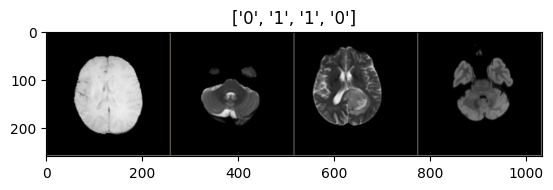

In [ ]:

inputs, classes = next(iter(dataloaders['TRAIN']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## ResNet18 Model

The train_model function defines a training function for a PyTorch model. The function trains the model for a specified number of epochs, updating weights and optimizing performance during training. 

In [ ]:
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    #record the start time
    since=time.time()
    
    #initialize variables to track the best model's weights and accuracy
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    #iterate over the specified number of epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        #each epoch has a training and validation phase
        for phase in ['TRAIN', 'VAL']:
            if phase=='TRAIN':
                model.train() #set model to training mode
            elif phase=='VAL':
                model.eval() #set model to evaluate mode
                
            running_loss=0.0
            running_corrects=0
            
            #iterate over batches of data
            for inputs, labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                #forward pass
                with torch.set_grad_enabled(phase=='TRAIN'):
                    outputs=model(inputs)
                    _, preds=torch.max(outputs, 1)
                    loss=criterion(outputs, labels)
                    
                    #backward pass and optimization only during training phase
                    if phase=='TRAIN':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                
                #statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
                
            #adjust learning rate during trainin phase
            if phase=='TRAIN':
                scheduler.step()
            
            #calculate epoch loss and accuracy
            epoch_loss=running_loss/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #save the best model weights based on validation accuracy
            if phase=='VAL' and epoch_acc>best_acc:
                best_acc=epoch_acc
                #save the best model weights to a file
                torch.save(model, model_name + 'weights.pt')
        
        print() 
        
    #calculate and print the total training time
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

This code is a basic setup for training a modified ResNet18 model on a binary classification task. It's a common practice to fine-tune pre-trained models for specific tasks.

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Modeli oluştur
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# Modelin özetini yazdır
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [23]:
#load pre-trained Resnet18 model
resnet=models.resnet18(pretrained=True)

#get the number of input features for the fully connected layer
num_ftrs=resnet.fc.in_features

#replace the fully connected layer with a new one for binary classification (2 classes)
resnet.fc=nn.Linear(num_ftrs, 2)

#move the model to the specified device (cpu or gpu)
resnet=resnet.to(device)

#define the loss function for classification (CrossEntropyLoss)
criterion=nn.CrossEntropyLoss()

#define the optimizer for parameter optimization (Stochastic Gradient Descent - SGD)
optimizer=optim.SGD(resnet.parameters(), lr=0.001)

#define the learning rate scheduler (StepLR scheduler with step_size=7 and gamma=0.1)
step_lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#train the modified ResNet model for one epoch using the custom train_model function
train_model(resnet, 'resnet', criterion, optimizer, step_lr_scheduler, num_epochs=30)



Epoch 1/30
30/30 [==============================] - 26s 5184ms/step - loss: 3.0781 - acc: 0.6049 - val_loss: 2.2196 - val_acc: 0.7563
Epoch 2/30
30/30 [==============================] - 24s 4763ms/step - loss: 2.2948 - acc: 0.7411 - val_loss: 2.0424 - val_acc: 0.8006
Epoch 3/30
30/30 [==============================] - 23s 4654ms/step - loss: 2.1530 - acc: 0.7635 - val_loss: 1.9332 - val_acc: 0.8418
Epoch 4/30
30/30 [==============================] - 23s 4683ms/step - loss: 1.9035 - acc: 0.7910 - val_loss: 1.5734 - val_acc: 0.8609
Epoch 5/30
30/30 [==============================] - 24s 4714ms/step - loss: 2.0054 - acc: 0.7719 - val_loss: 1.2197 - val_acc: 0.8418
Epoch 6/30
30/30 [==============================] - 23s 4663ms/step - loss: 1.6505 - acc: 0.8236 - val_loss: 1.1466 - val_acc: 0.8829
Epoch 7/30
30/30 [==============================] - 23s 4513ms/step - loss: 1.0856 - acc: 0.8564 - val_loss: 1.2525 - val_acc: 0.8956
Epoch 8/30
30/30 [==============================] - 24s 4713m

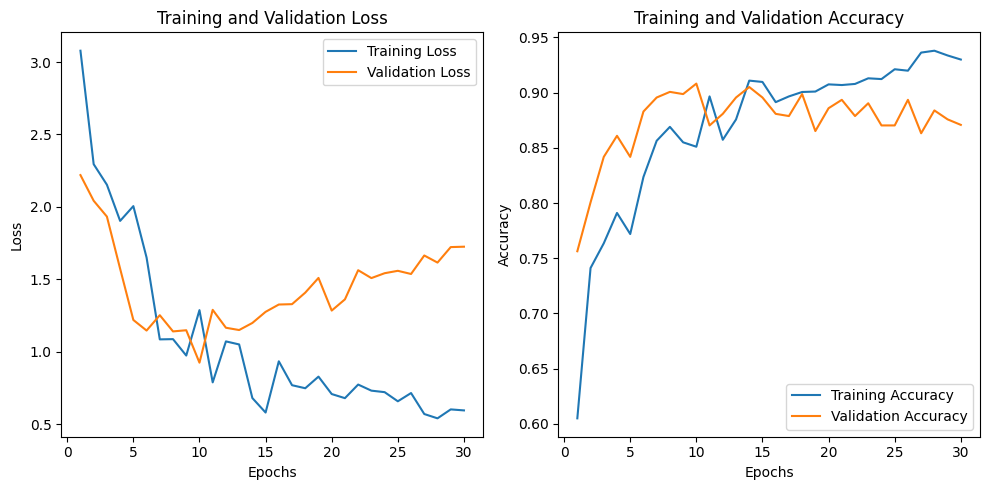

In [90]:

history = model.fit(...)  # Assuming you have already trained your Keras model

# Plotting the loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [83]:
def predict_random_sample(model, dataloaders, device):
    # Set the model to evaluation mode
    model.eval()

    # Get a random sample from the test data
    random_sample = next(iter(dataloaders['TEST']))

    # Extract inputs and labels from the random sample
    inputs, labels = random_sample
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    # Display the actual and predicted labels
    print("Actual Label: {}".format(labels.item()))
    print("Predicted Label: {}".format(preds.item()))

    # Extract BraTS21ID and MGMT value from the random sample
    brats21id = random_sample['BraTS21ID'].item()
    mgmt_value = random_sample['MGMT_value'].item()

    # Visualize the corresponding image
    visualize_data(brats21id=brats21id, mgmt_value=mgmt_value, slice_i=0.5)

    # Set the model back to training mode if needed
    model.train()


Sample 20: Actual MGMT Value: 1, Predicted Label: 1


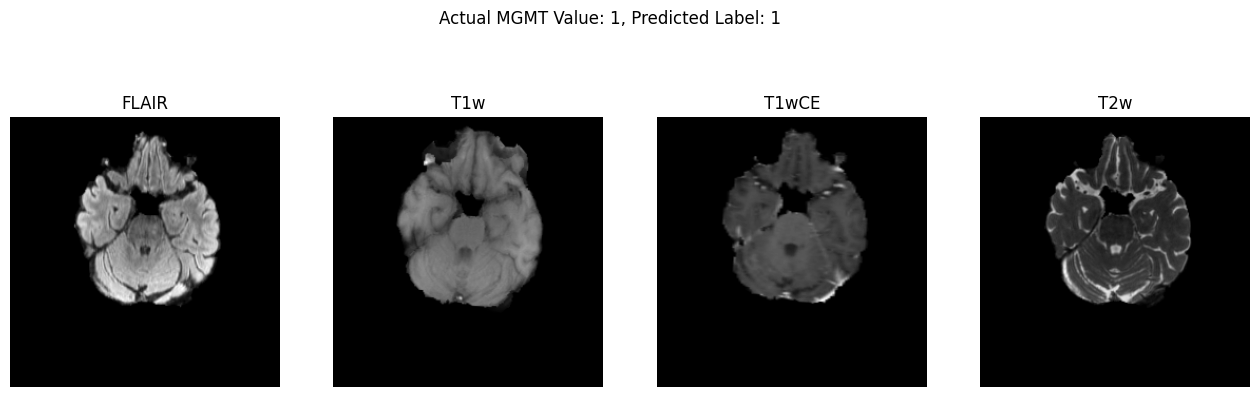

In [76]:
predict_random_sample(model, dataloaders, device)

Sample 210: Actual MGMT Value: 1, Predicted Label: 1


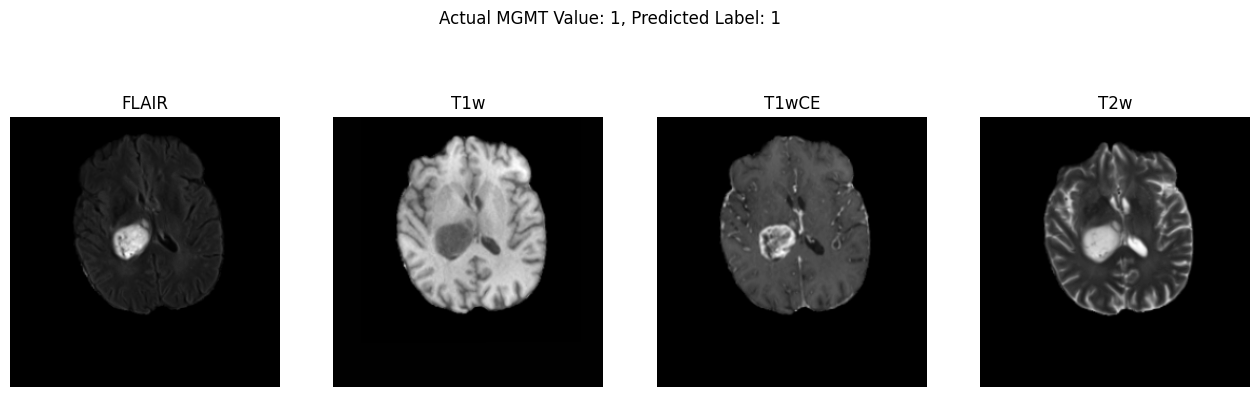

In [78]:
predict_random_sample(model, dataloaders, device)

Sample 618: Actual MGMT Value: 1, Predicted Label: 1


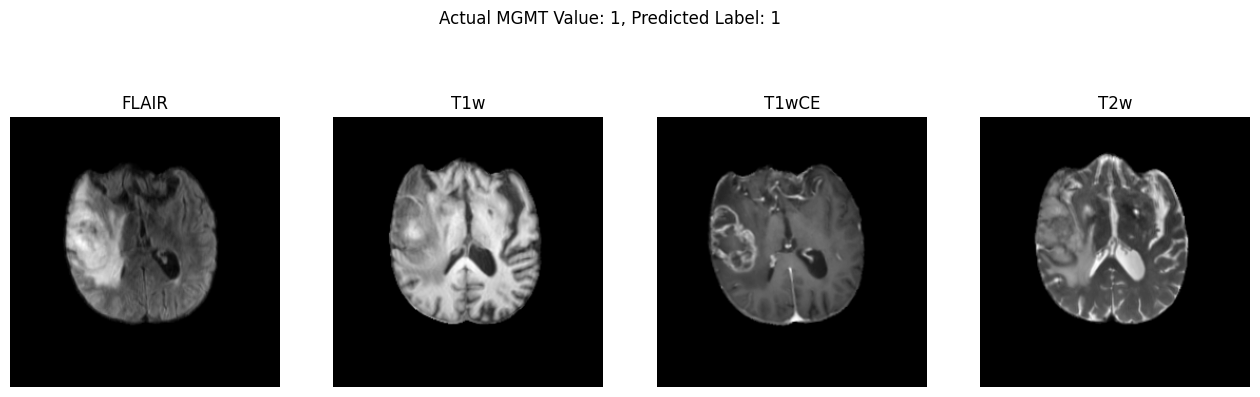

In [79]:
predict_random_sample(model, dataloaders, device)

Sample 11: Actual MGMT Value: 0, Predicted Label: 0


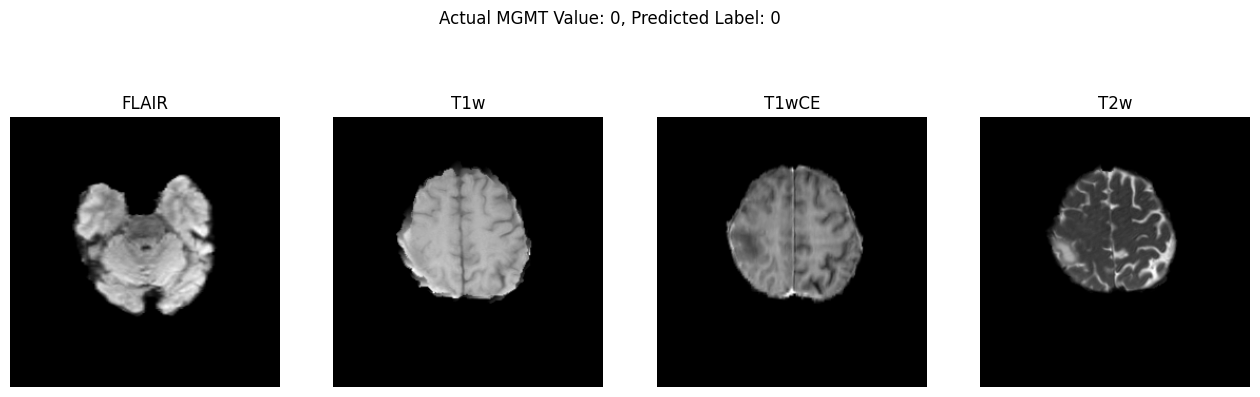

In [82]:
predict_random_sample(model, dataloaders, device)